In [3]:
import os
import sys

from huggingface_hub import get_token

from huggingface_hub import notebook_login
notebook_login()


### Install dependencies

In [4]:
! pip install --upgrade --quiet bitsandbytes datasets evaluate peft tensorboard transformers trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.5/532.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 11.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires tensorboard~=2.19.0, but you have tensorboard 2.20.0 which is incompatible.


## Prepare fine-tuning dataset

This notebook uses the [NCT-CRC-HE-100K](https://zenodo.org/records/1214456) dataset which is licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/legalcode), containing image patches from histological images of human colorectal cancer (CRC) and normal tissue, to fine-tune MedGemma to classify tissue types.

**Note:** The full NCT-CRC-HE-100K dataset contains 100K samples. By default this guide only uses a subset with 10,000 samples to keep the training example small, but you can adjust this number if you want to experiment.

**Dataset citation:** Kather, J. N., Halama, N., & Marx, A. (2018). 100,000 histological images of human colorectal cancer and healthy tissue (v0.1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.1214456

Download the dataset. This step may take around 15 minutes to complete.

## dataset loading

In [5]:
! wget -nc -q "https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip"
! unzip -q CRC-VAL-HE-7K.zip

Load the data using the Hugging Face `datasets` library. Then, create train and validation splits.

In [7]:
from datasets import load_dataset

train_size = 500  # @param {type: "number"}
validation_size = 50  # @param {type: "number"}

data = load_dataset("./CRC-VAL-HE-7K", split="train")
data = data.train_test_split(
    train_size=train_size,
    test_size=validation_size,
    shuffle=True,
    seed=42,
)
# Use the test split as the validation set
data["validation"] = data.pop("test")

# Display dataset details
data

Resolving data files:   0%|          | 0/7180 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 50
    })
})

Inspect a sample data point, which contains:

* `image`: image patch as a `PIL` image object
* `label`: integer class label corresponding to tissue type

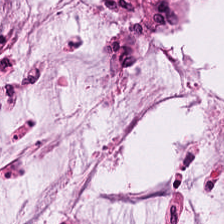

In [8]:
data["train"][0]["image"]

In [9]:
data["train"][0]["label"]

4

For this classification task, create a multiple-choice question prompt and preprocess the data into a multimodal conversational format.

In [10]:
from typing import Any

TISSUE_CLASSES = [
    "A: adipose",
    "B: background",
    "C: debris",
    "D: lymphocytes",
    "E: mucus",
    "F: smooth muscle",
    "G: normal colon mucosa",
    "H: cancer-associated stroma",
    "I: colorectal adenocarcinoma epithelium"
]

options = "\n".join(TISSUE_CLASSES)
PROMPT = f"What is the most likely tissue type shown in the histopathology image?\n{options}"


def format_data(example: dict[str, Any]) -> dict[str, Any]:
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {
                    "type": "text",
                    "text": PROMPT,
                },
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": TISSUE_CLASSES[example["label"]],
                },
            ],
        },
    ]
    return example

Apply the processing function on the dataset.

In [11]:
data = data.map(format_data)

# Display a processed data sample
data["train"][0]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'image': <PIL.Image.Image image mode=RGB size=224x224>,
 'label': 4,
 'messages': [{'content': [{'text': None, 'type': 'image'},
    {'text': 'What is the most likely tissue type shown in the histopathology image?\nA: adipose\nB: background\nC: debris\nD: lymphocytes\nE: mucus\nF: smooth muscle\nG: normal colon mucosa\nH: cancer-associated stroma\nI: colorectal adenocarcinoma epithelium',
     'type': 'text'}],
   'role': 'user'},
  {'content': [{'text': 'E: mucus', 'type': 'text'}], 'role': 'assistant'}]}

## Fine-tune the model with LoRA

Traditional fine-tuning of large language models is resource-intensive because it requires adjusting billions of parameters. Parameter-Efficient Fine-Tuning (PEFT) addresses this by training a smaller number of parameters. A common PEFT technique is Low-Rank Adaptation (LoRA), which efficiently adapts large language models by training small, low-rank matrices that are added to the original model instead of updating the full-weight matrices. In QLoRA, the base model is quantized to 4-bit before its weights are frozen, then LoRA adapter layers are attached and trained.

This notebook demonstrates supervised fine-tuning MedGemma with QLoRA using the `SFTTrainer` from the Hugging Face `TRL` library.

### Load model from Hugging Face Hub

Initialize the quantization configuration and load the model.

In [ ]:
# model_id = "google/gemma-7b-it"
# # model_id = "google/gemma-7b"
# # model_id = "google/gemma-2b-it"
# # model_id = "google/gemma-2b"

# model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})
# tokenizer = AutoTokenizer.from_pretrained(model_id, add_eos_token=True)

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

model_id = "google/medgemma-4b-it"

# Check if GPU supports bfloat16
# if torch.cuda.get_device_capability()[0] < 8:
#     raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.float16,
    device_map={"":0},
)

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained(model_id)

# Use right padding to avoid issues during training
processor.tokenizer.padding_side = "right"

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

### Set up for fine-tuning

Create a [`LoraConfig`](https://huggingface.co/docs/peft/package_reference/lora#peft.LoraConfig). It will be provided to the `SFTTrainer`, which supports built-in integration with the Hugging Face `PEFT` library.

In [ ]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=2,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

Define a custom data collator that processes examples containing text and images and returns batches of data in the expected model input format.

In [1]:
from typing import Any


def collate_fn(examples: list[dict[str, Any]]):
    texts = []
    images = []
    for example in examples:
        images.append([example["image"].convert("RGB")])
        texts.append(processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        ).strip())

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # The labels are the input_ids, with the padding and image tokens masked in
    # the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]
    # Mask tokens that are not used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch

Configure training parameters in an [`SFTConfig`](https://huggingface.co/docs/trl/sft_trainer#trl.SFTConfig).

In [ ]:
from trl import SFTConfig

num_train_epochs = 1  # @param {type: "number"}
learning_rate = 2e-4  # @param {type: "number"}

args = SFTConfig(
    output_dir="medgemma-4b-it-sft-lora-crc100k",            # Directory and Hub repository id to save the model to
    num_train_epochs=num_train_epochs,                       # Number of training epochs
    per_device_train_batch_size=4,                           # Batch size per device during training
    per_device_eval_batch_size=4,                            # Batch size per device during evaluation
    gradient_accumulation_steps=4,                           # Number of steps before performing a backward/update pass
    gradient_checkpointing=True,                             # Enable gradient checkpointing to reduce memory usage
    optim="adamw_torch_fused",                               # Use fused AdamW optimizer for better performance
    logging_steps=50,                                        # Number of steps between logs
    save_strategy="epoch",                                   # Save checkpoint every epoch
    eval_strategy="steps",                                   # Evaluate every `eval_steps`
    eval_steps=50,                                           # Number of steps between evaluations
    learning_rate=learning_rate,                             # Learning rate based on QLoRA paper
    bf16=True,                                               # Use bfloat16 precision
    max_grad_norm=0.3,                                       # Max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                                       # Warmup ratio based on QLoRA paper
    lr_scheduler_type="linear",                              # Use linear learning rate scheduler
    push_to_hub=True,                                        # Push model to Hub
    report_to="tensorboard",                                 # Report metrics to tensorboard
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Set gradient checkpointing to non-reentrant to avoid issues
    dataset_kwargs={"skip_prepare_dataset": True},           # Skip default dataset preparation to preprocess manually
    remove_unused_columns = False,                           # Columns are unused for training but needed for data collator
    label_names=["labels"],                                  # Input keys that correspond to the labels
)

### Fine-tune the model

Construct an [`SFTTrainer`](https://huggingface.co/docs/trl/sft_trainer) using the previously defined LoRA configuration, custom data collator, and training parameters.

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=data["train"],
    eval_dataset=data["validation"].shuffle().select(range(200)),  # Use subset of validation set for faster run
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)

Launch the fine-tuning process.

**Note**: This may take around 3 hours to run using the default configuration.

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
50,4.520300,0.032325
100,0.103300,0.026194
150,0.093900,0.021495
200,0.088900,0.022999
250,0.085500,0.021236
300,0.082200,0.020522
350,0.083400,0.020533
400,0.081500,0.019521
450,0.079800,0.019584
500,0.078200,0.019550


TrainOutput(global_step=562, training_loss=0.4797590243434567, metrics={'train_runtime': 10581.2693, 'train_samples_per_second': 0.851, 'train_steps_per_second': 0.053, 'total_flos': 7.820988839186266e+16, 'train_loss': 0.4797590243434567})

Save the final model to Hugging Face Hub.

In [ ]:
trainer.save_model()

Free up memory before proceeding to evaluate and test the fine-tuned model.

In [ ]:
del model
del trainer
torch.cuda.empty_cache()

## Evaluate the fine-tuned model

### Prepare test dataset

The [CRC-VAL-HE-7K](https://zenodo.org/records/1214456) dataset contains image patches from patients with colorectal adenocarcinoma and does not overlap with NCT-CRC-HE-100K. It can be used as the test dataset to evaluate the fine-tuned MedGemma model.

**Note:** The full CRC-VAL-HE-7K dataset contains over 7K samples. By default this guide only uses a subset with 1,000 samples to keep the evaluation example small.

Download and prepare the test dataset.

In [ ]:
! wget -nc -q "https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip"
! unzip -q CRC-VAL-HE-7K.zip

In [ ]:
from typing import Any

from datasets import load_dataset


def format_test_data(example: dict[str, Any]) -> dict[str, Any]:
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {
                    "type": "text",
                    "text": PROMPT,
                },
            ],
        },
    ]
    return example


test_data = load_dataset("./CRC-VAL-HE-7K", split="train")
test_data = test_data.shuffle(seed=42).select(range(1000))
test_data = test_data.map(format_test_data)

### Set up for evaluation

Load the accuracy and F1 score metrics to evaluate the model's performance on the classfication task.

In [ ]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Ground-truth labels
REFERENCES = test_data["label"]


def compute_metrics(predictions: list[int]) -> dict[str, float]:
    metrics = {}
    metrics.update(accuracy_metric.compute(
        predictions=predictions,
        references=REFERENCES,
    ))
    metrics.update(f1_metric.compute(
        predictions=predictions,
        references=REFERENCES,
        average="weighted",
    ))
    return metrics

Define a postprocessing function to convert responses to integer class labels before computing metrics.

In [ ]:
from datasets import ClassLabel

# Rename the class names to the tissue classes, `X: tissue type`
test_data = test_data.cast_column(
    "label",
    ClassLabel(names=TISSUE_CLASSES)
)

LABEL_FEATURE = test_data.features["label"]
# Mapping to alternative label format, `(X) tissue type`
ALT_LABELS = dict([
    (label, f"({label.replace(': ', ') ')}") for label in TISSUE_CLASSES
])


def postprocess(prediction: list[dict[str, str]], do_full_match: bool=False) -> int:
    response_text = prediction[0]["generated_text"]
    if do_full_match:
        return LABEL_FEATURE.str2int(response_text)
    for label in TISSUE_CLASSES:
        # Search for `X: tissue type` or `(X) tissue type` in the response
        if label in response_text or ALT_LABELS[label] in response_text:
            return LABEL_FEATURE.str2int(label)
    return -1

### Compute baseline metrics on the pretrained model

Load the pretrained model using the `pipeline` API.

In [ ]:
from transformers import pipeline

pt_pipe = pipeline(
    "image-text-to-text",
    model=model_id,
    torch_dtype=torch.bfloat16,
)

# Set `do_sample = False` for deterministic responses
pt_pipe.model.generation_config.do_sample = False
pt_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id

Run batch inference on the test dataset.

In [ ]:
pt_outputs = pt_pipe(
    text=test_data["messages"],
    images=test_data["image"],
    max_new_tokens=40,
    batch_size=64,
    return_full_text=False,
)

pt_predictions = [postprocess(out) for out in pt_outputs]

Compute metrics.

In [ ]:
pt_metrics = compute_metrics(pt_predictions)
print(f"Baseline metrics: {pt_metrics}")

Baseline metrics: {'accuracy': 0.43, 'f1': 0.3520150005688922}


### Compute metrics on the fine-tuned model

Load the base model with the fine-tuned LoRA adapter using the `pipeline` API.

In [ ]:
ft_pipe = pipeline(
    "image-text-to-text",
    model=args.output_dir,
    processor=processor,
    torch_dtype=torch.bfloat16,
)

# Set `do_sample = False` for deterministic responses
ft_pipe.model.generation_config.do_sample = False
ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id
# Use left padding during inference
processor.tokenizer.padding_side = "left"

Run batch inference on the test dataset.

In [ ]:
ft_outputs = ft_pipe(
    text=test_data["messages"],
    images=test_data["image"],
    max_new_tokens=20,
    batch_size=64,
    return_full_text=False,
)

ft_predictions = [postprocess(out, do_full_match=True) for out in ft_outputs]

Compute metrics.

In [ ]:
ft_metrics = compute_metrics(ft_predictions)
print(f"Fine-tuned metrics: {ft_metrics}")

Fine-tuned metrics: {'accuracy': 0.945, 'f1': 0.9440669568493043}


# Next steps

Explore the other [notebooks](https://github.com/google-health/medgemma/blob/main/notebooks) to learn what else you can do with the model.